In [1]:
import pandas as pd

diamonds = pd.read_csv(r'/Users/murasame/Desktop/diamonds.csv').drop("Unnamed: 0", axis=1)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
'''
Надо определить бизнес- задачу, чтобы потом выбрать метрику
Задача: Предсказать класс камня
Нет особых указаний (например, что надо в основном предсказывать только 
Premium тк компания продает покупает только их.)
поэтому буду добиваться хороших результатов по всем, выберу метрику, которая даст "общий" ответ
Какие метрики буду использовать:
NxN matrix - самая лучшая визуализация для мн класс
F1 score - спойлер: я построил график и увидел дисбаланс классов, поэтому предпочел ее ROC-AUC

'''

In [2]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
'''Нет пропущенных значений, поэтому на этапе предварительной обработки надо
только отмасштабировать данные, сейчас посмотрю через гистограммы какие и как'''

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024736A5ED90>,
      dtype=object)

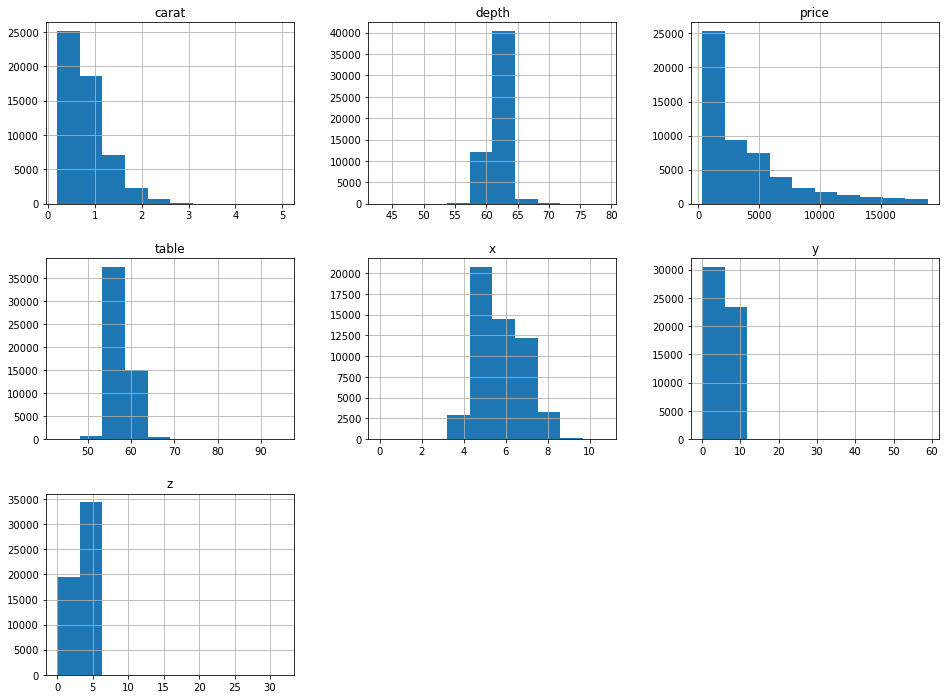

In [5]:
diamonds.hist(figsize=(16, 12))

In [6]:
#для price и carat необходим log трансформатор
#есть желание посмотреть подробнее цены, конкретно на счет выбросов 


{'whiskers': [<matplotlib.lines.Line2D at 0x2473f461f40>,
 'caps': [<matplotlib.lines.Line2D at 0x2473f44a490>,
 'boxes': [<matplotlib.lines.Line2D at 0x2473f461640>],
 'medians': [<matplotlib.lines.Line2D at 0x2473fce0730>],
 'fliers': [<matplotlib.lines.Line2D at 0x2473fce0a30>],
 'means': []}

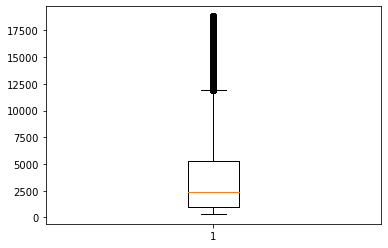

In [15]:
plt.boxplot(diamonds.price)

In [16]:
diamonds.price.median()

2401.0

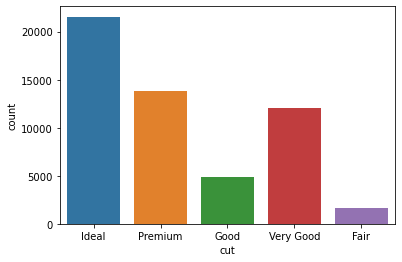

In [3]:
'''Интересно, а каких камней больше всего?
'''
import seaborn as sns
sns.countplot(x="cut", data=diamonds)

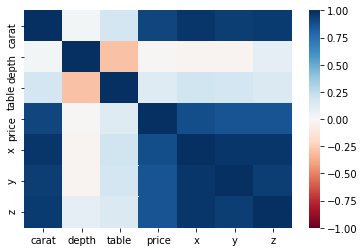

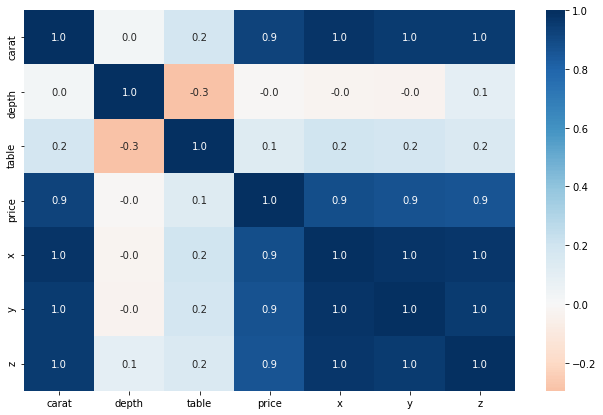

In [7]:
import matplotlib.pyplot as plt
corr = diamonds.corr()
sns.heatmap(corr,xticklabels=corr.columns,
           yticklabels=corr.columns, vmin = -1, vmax = 1, cmap = 'RdBu')
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr,annot=True,fmt='.1f',cmap='RdBu',center=0,ax=ax)


In [10]:
'''z y x идеально коррелируют между собой и carat
тк Если две числовые характеристики идеально коррелируют,
то одна из них не добавляет никакой дополнительной информации (она определяется другой), то можно было бы удалить z,x,y, но
с другой стороны у нас не так много признаков, и не хотелось бы потерять информативность, избавившись от 
x
length in mm (0--10.74)
y
width in mm (0--58.9)
z
depth in mm (0--31.8)
Забегая вперед, я попробовал не удаляя признаки и лучший вариант моделей без настройки был 0.75 f1 score. Меня такое значение не
устраивает, поэтому я все же удалю их, да и считаться будет быстреe. 
'''

'z y x идеально коррелируют между собой и carat\nтк Если две числовые характеристики идеально коррелируют,\nто одна из них не добавляет никакой дополнительной информации (она определяется другой), то можно было бы удалить z,x,y, но\nс другой стороны у нас не так много признаков, и не хотелось бы потерять информативность, избавившись от \nx\nlength in mm (0--10.74)\ny\nwidth in mm (0--58.9)\nz\ndepth in mm (0--31.8)\nЗабегая вперед, я попробовал не удаляя признаки и лучший вариант моделей без настройки был 0.75 f1 score. Меня такое значение не\nустраивает, поэтому я все же удалю их, да и считаться будет быстре. \n'

In [2]:
diamonds = diamonds[['carat','depth','table','price','cut','color','clarity']]

In [3]:
diamonds.head(1)

,carat,depth,table,price,cut,color,clarity
0,0.23,61.5,55.0,326,Ideal,E,SI2


In [4]:
from sklearn.model_selection import train_test_split


X, y = diamonds.drop("cut", axis=1), diamonds["cut"].values.flatten()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=54, test_size=0.3, stratify=y
)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder, PowerTransformer, StandardScaler
  )


categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown="ignore")
  )


to_log = ["price", "carat"]
to_scale = ["depth", "table"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())


full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)



pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            GradientBoostingClassifier(),
        ),
    ]
)

GB_pipeline = pipeline.fit(X_train, y_train)

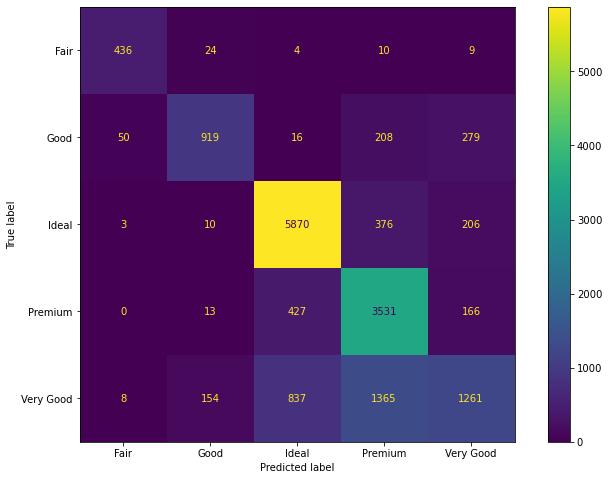

              precision    recall  f1-score   support

        Fair       0.88      0.90      0.89       483
        Good       0.82      0.62      0.71      1472
       Ideal       0.82      0.91      0.86      6465
     Premium       0.64      0.85      0.73      4137
   Very Good       0.66      0.35      0.45      3625

    accuracy                           0.74     16182
   macro avg       0.76      0.73      0.73     16182
weighted avg       0.74      0.74      0.72     16182

CPU times: user 1.48 s, sys: 168 ms, total: 1.64 s
Wall time: 1.91 s


In [14]:
%%time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred_GB = GB_pipeline.predict(X_test)

fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_pred_GB)
cmp = ConfusionMatrixDisplay(cm, display_labels=GB_pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

from sklearn.metrics import roc_auc_score

print(classification_report(y_test, y_pred_GB))

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


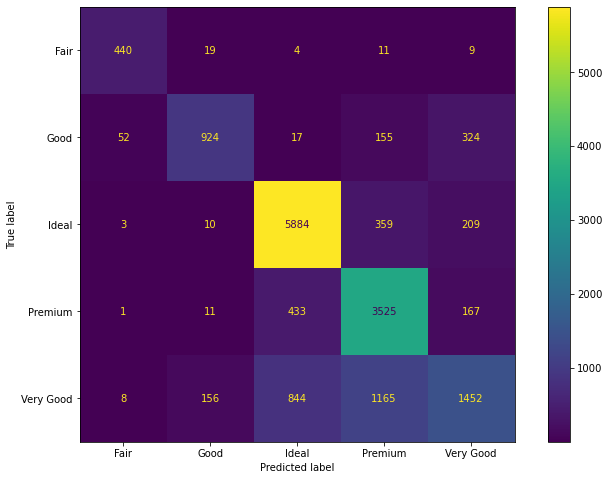

              precision    recall  f1-score   support

        Fair       0.81      0.45      0.58       483
        Good       0.49      0.13      0.21      1472
       Ideal       0.72      0.87      0.79      6465
     Premium       0.65      0.71      0.68      4137
   Very Good       0.48      0.43      0.45      3625

    accuracy                           0.65     16182
   macro avg       0.63      0.52      0.54     16182
weighted avg       0.63      0.65      0.63     16182



In [19]:
from sklearn.linear_model import LogisticRegression
LRpipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            LogisticRegression(multi_class='multinomial'),
        ),
    ]
)

LRpipeline.fit(X_train, y_train)

y_pred_LR = LRpipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_GB)
cmp = ConfusionMatrixDisplay(cm, display_labels=LRpipeline.classes_)
cmp.plot(ax=ax)

plt.show();

print(classification_report(y_test, y_pred_LR))

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


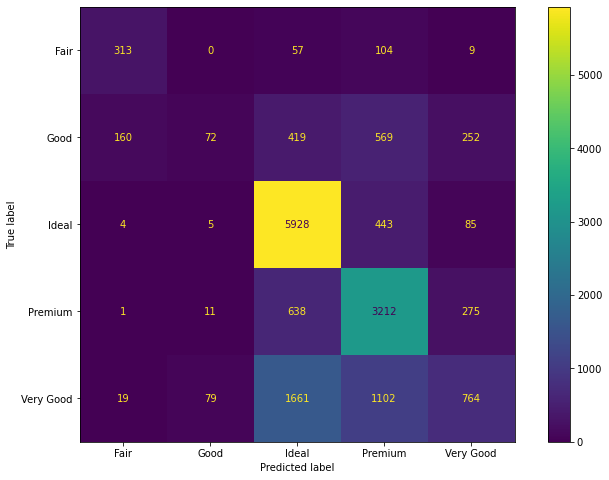

              precision    recall  f1-score   support

        Fair       0.63      0.65      0.64       483
        Good       0.43      0.05      0.09      1472
       Ideal       0.68      0.92      0.78      6465
     Premium       0.59      0.78      0.67      4137
   Very Good       0.55      0.21      0.30      3625

    accuracy                           0.64     16182
   macro avg       0.58      0.52      0.50     16182
weighted avg       0.60      0.64      0.58     16182



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
SVCpipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            LinearSVC(multi_class='crammer_singer'),
        ),
    ]
)

SVCpipeline.fit(X_train, y_train)

y_pred_SVC = SVCpipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_SVC)
cmp = ConfusionMatrixDisplay(cm, display_labels=SVCpipeline.classes_)
cmp.plot(ax=ax)

plt.show();
print(classification_report(y_test, y_pred_SVC))

In [22]:
from sklearn.tree import DecisionTreeClassifier


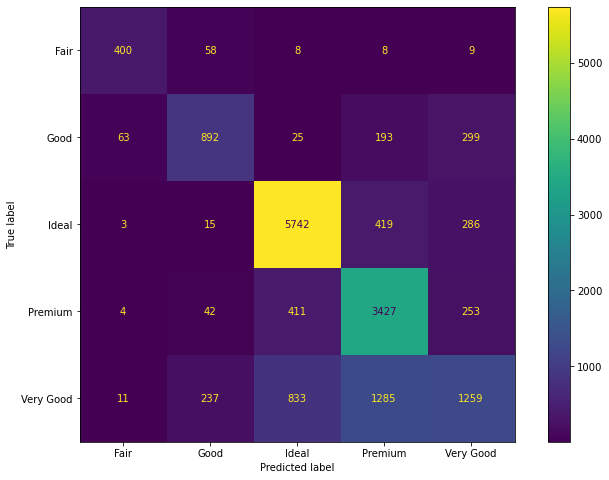

              precision    recall  f1-score   support

        Fair       0.83      0.83      0.83       483
        Good       0.72      0.61      0.66      1472
       Ideal       0.82      0.89      0.85      6465
     Premium       0.64      0.83      0.72      4137
   Very Good       0.60      0.35      0.44      3625

    accuracy                           0.72     16182
   macro avg       0.72      0.70      0.70     16182
weighted avg       0.72      0.72      0.71     16182



In [33]:
DTpipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            DecisionTreeClassifier(max_depth = 15,min_samples_split = 5),
        ),
    ]
)

DTpipeline.fit(X_train, y_train)

y_pred_DT = DTpipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_DT)
cmp = ConfusionMatrixDisplay(cm, display_labels=DTpipeline.classes_)
cmp.plot(ax=ax)

plt.show();
print(classification_report(y_test, y_pred_DT))

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

classifiers = [
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    KNeighborsClassifier(),
    LinearSVC(multi_class='crammer_singer'),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[("preprocess", full),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classifier)
    print("model score: %.3f" % f1_score(y_test, y_pred,average="weighted"))

DecisionTreeClassifier()
model score: 0.657
ExtraTreeClassifier()
model score: 0.567
KNeighborsClassifier()
model score: 0.647


/Users/murasame/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(multi_class='crammer_singer')
model score: 0.487
RandomForestClassifier()
model score: 0.706
GradientBoostingClassifier()
model score: 0.725
SGDClassifier()
model score: 0.442


In [ ]:
'''
RandomForestClassifier()
model score: 0.759
GradientBoostingClassifier()
model score: 0.741

Буду настраивать эти две модели, а потом попробую XGB, хочу не сразу запустить GridSearch, а
сначала с помощью кривых валидации определить диапазоны, которые вообще не стоит перебирать, чтобы не давать
на брутфорс слишком много параметров.
'''

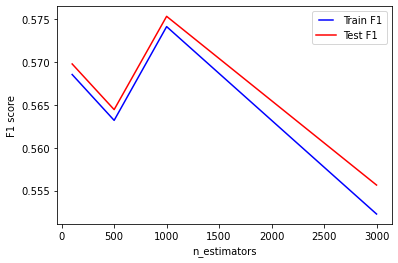

In [44]:
n_estimators = [100,500,1000,3000]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = Pipeline(steps=[("preprocess", full),
                      ('RandomForestClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

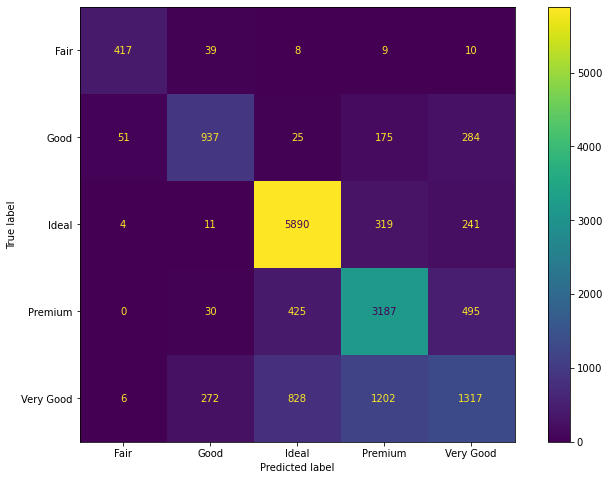

              precision    recall  f1-score   support

        Fair       0.87      0.86      0.87       483
        Good       0.73      0.64      0.68      1472
       Ideal       0.82      0.91      0.86      6465
     Premium       0.65      0.77      0.71      4137
   Very Good       0.56      0.36      0.44      3625

    accuracy                           0.73     16182
   macro avg       0.73      0.71      0.71     16182
weighted avg       0.71      0.73      0.71     16182



In [63]:
RFpipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            RandomForestClassifier(max_depth=23,
                                        n_estimators=1100),
        ),
    ]
)

RFpipeline.fit(X_train, y_train)

y_pred_RF = RFpipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_RF)
cmp = ConfusionMatrixDisplay(cm, display_labels=RFpipeline.classes_)
cmp.plot(ax=ax)

plt.show();
print(classification_report(y_test, y_pred_RF))

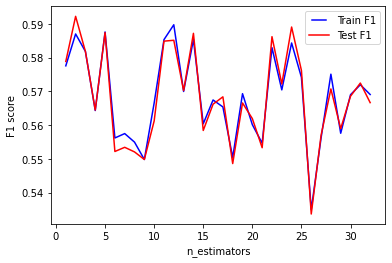

In [46]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = Pipeline(steps=[("preprocess", full),
                      ('RandomForestClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

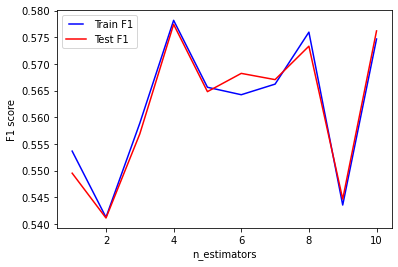

In [59]:
min_samples_splits = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = Pipeline(steps=[("preprocess", full),
                      ('RandomForestClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

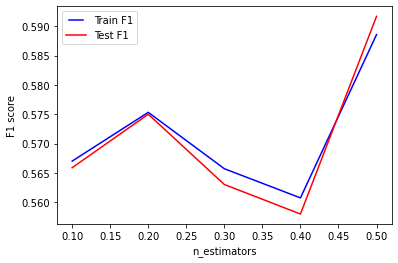

In [49]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = Pipeline(steps=[("preprocess", full),
                      ('RandomForestClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

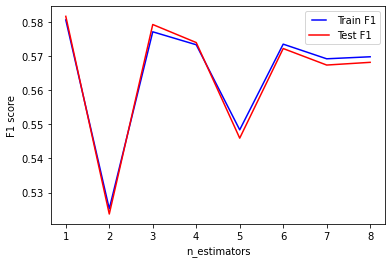

In [53]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = Pipeline(steps=[("preprocess", full),
                      ('RandomForestClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train F1')
line2, = plt.plot(max_features, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

In [46]:
#настройка параметров для леса
#лучшие значения параметров после кривых
n_estimators = [900,1000,1100]
max_depths = [3,5,15,23]
#min_samples_splits = [4,8]
min_samples_leafs = [0.45,0.50,0.55]
#max_features = [3,6]

param_grid = {
    'base__n_estimators' : n_estimators,
    'base__max_depth' : max_depths,
    #'base__min_samples_split' : min_samples_splits,
    'base__min_samples_leaf' : min_samples_leafs,
    #'base__max_features' : max_features
}

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV

hrs = GridSearchCV(RFpipeline, param_grid,
    cv=3,
    n_jobs=-1,
)

_ = hrs.fit(X_train, y_train)

best_estimator = _.best_estimator_

/Users/murasame/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.39954447 0.39954447 0.39954447 0.39954447 0.39954447 0.39954447
        nan        nan        nan 0.39954447 0.39954447 0.39954447
 0.39954447 0.39954447 0.39954447        nan        nan        nan
 0.39954447 0.39954447 0.39954447 0.39954447 0.39954447 0.39954447
        nan        nan        nan 0.39954447 0.39954447 0.39954447
 0.39954447 0.39954447 0.39954447        nan        nan        nan]
  warnings.warn(


In [48]:
hrs.best_score_

0.3995444673976376

/Users/murasame/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/murasame/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/murasame/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Fair       0.00      0.00      0.00       483
        Good       0.00      0.00      0.00      1472
       Ideal       0.40      1.00      0.57      6465
     Premium       0.00      0.00      0.00      4137
   Very Good       0.00      0.00      0.00      3625

    accuracy                           0.40     16182
   macro avg       0.08      0.20      0.11     16182
weighted avg       0.16      0.40      0.23     16182



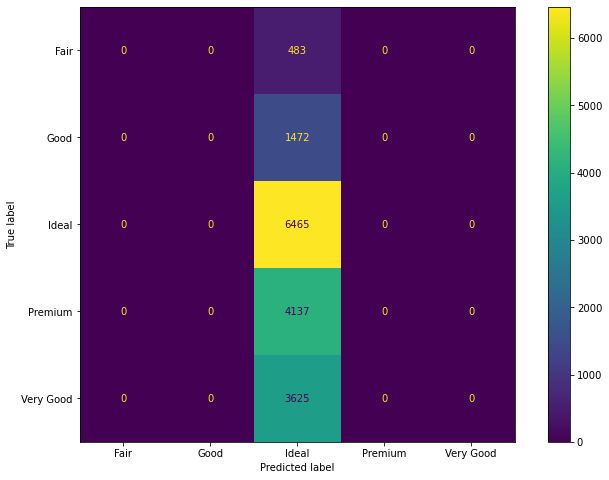

In [39]:
rf_pred = best_estimator.predict(X_test)
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, rf_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=best_estimator.classes_)
cmp.plot(ax=ax)

print(classification_report(y_test,rf_pred))

In [40]:
best_estimator

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['color', 'clarity']),
                                                 ('power_transform',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['price', 'carat']),
                                                 ('standardization',
                                                  Pipeline(steps=[('standardscaler',
                                                                   Stan

In [52]:
'''Кривые обучение сильно помогли, тк с гридсерчем произошел непонятный баг, теперь также 
подберу оптимальные параметры для бустинга, ведь на гридсерче он считается еще дольше, еще один плюс кривых
в том, что я не просто узнаю лучшие парметры, но и проверю, нет ли переобучения'''

'Кривые обучение сильно помогли, тк с гридсерчем произошел непонятный баг, теперь также \nподберу оптимальные параметры для бустинга, ведь на гридсерче он считается еще дольше, еще один плюс кривых\nв том, что я не просто узнаю лучшие парметры, но и проверю, нет ли переобучения'

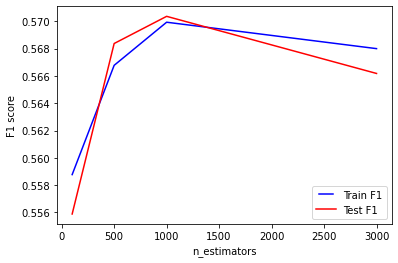

In [70]:
n_estimators = [100,500,1000,3000]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = Pipeline(steps=[("preprocess", full),
                      ('GradientBoosterClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

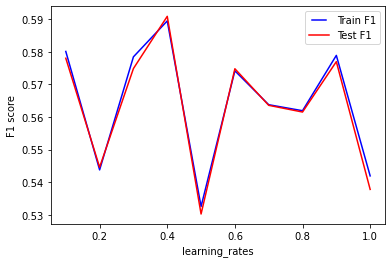

In [71]:
learning_rates = np.linspace(0.1, 1, 10, endpoint=True)
train_results = []
test_results = []
for learning_rate in learning_rates:
   rf = Pipeline(steps=[("preprocess", full),
                      ('GradientBoosterClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train F1')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('learning_rates')
plt.show()

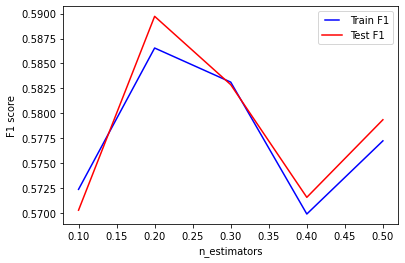

In [72]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = Pipeline(steps=[("preprocess", full),
                      ('GradientBoosterClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

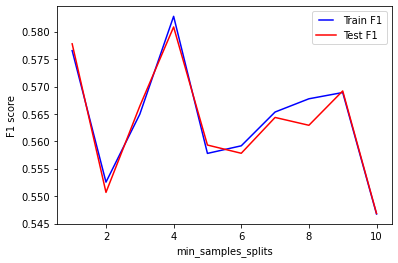

In [73]:
min_samples_splits = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = Pipeline(steps=[("preprocess", full),
                      ('GradientBoosterClassifier', classifier)])
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   model_score = f1_score(y_train, train_pred,average="weighted")
   train_results.append(model_score)
   y_pred = rf.predict(X_test)
   model_score = f1_score(y_test, y_pred,average="weighted")
   test_results.append(model_score)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_splits')
plt.show()

In [51]:
n_estimators = [900,1000,1100]
learning_rate = [0.4]
min_samples_splits = [4]
min_samples_leafs = [0.20]
#max_features = [3,6]

param_grid = {
    'base__n_estimators' : n_estimators,
    'base__learning_rate' : max_depths,
    #'base__min_samples_split' : min_samples_splits,
    'base__min_samples_leaf' : min_samples_leafs,
    #'base__max_features' : max_features
}

hrs = GridSearchCV(GB_pipeline, param_grid,
    cv=3,
    n_jobs=-1,
    verbose = 10
)

_ = hrs.fit(X_train, y_train)

best_estimator = _.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [54]:
hrs.best_params_

{'base__learning_rate': 3,
 'base__min_samples_leaf': 0.2,
 'base__n_estimators': 900}

              precision    recall  f1-score   support

        Fair       0.55      0.19      0.28       483
        Good       0.39      0.24      0.29      1472
       Ideal       0.82      0.88      0.85      6465
     Premium       0.60      0.77      0.67      4137
   Very Good       0.41      0.32      0.36      3625

    accuracy                           0.65     16182
   macro avg       0.55      0.48      0.49     16182
weighted avg       0.62      0.65      0.63     16182



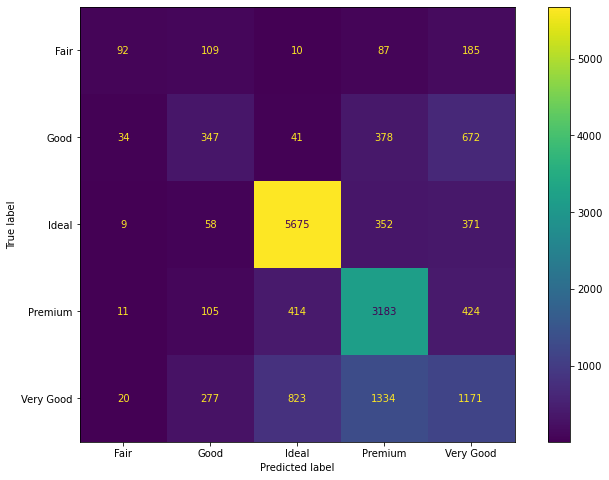

In [60]:
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            GradientBoostingClassifier(learning_rate=0.3,min_samples_leaf=0.2, n_estimators=900, 
                                       min_samples_split=4),
        ),
    ]
)

GB_pipeline = pipeline.fit(X_train, y_train)
gb_pred = GB_pipeline.predict(X_test)
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, gb_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=best_estimator.classes_)
cmp.plot(ax=ax)

print(classification_report(y_test,gb_pred))

In [64]:
'''Результаты после настройки черед грид серч вышли хуже, чем для 
дефолтной моели. Это может смущать, но такое вполне возможно. Гридсерч - это всего лишь попытка
улучшить показатели модели, которая может увенчаться успехом, а может и не сработать. Правда 
для Ideal вообще отличный результат 0.85, тк это самый популярный класс, то можно сделать предположение,
что плачевные результаты для других меток обеспечены малым % содержания
соответствующим им образов в наборе данных. Для улучшения результата, можно было бы
посоветовать компании собрать больше данных. 

Итоговвые результаты

GradientBoostingClassifier():f1 = 0.74

RandomForestClassifier(max_depth=23, n_estimators=1100): f1 = 0.73
'''

'Результаты после настройки черед грид серч вышли хуже, чем для \nдефолтной моели. Это может смущать, но такое вполне возможно. Гридсерч - это всего лишь попытка\nулучшить показатели модели, которая может увенчаться успехом, а может и не сработать. Правда \nдля Ideal вообще отличный результат 0.85, тк это самый популярный класс, то можно сделать предположение,\nчто плачевные результаты для других меток обеспечены малым % содержания\nсоответствующим им образов в наборе данных. Для улучшения результата, можно было бы\nпосоветовать компании собрать больше данных. \n\nИтоговвые результаты\n\nGradientBoostingClassifier():f1 = 0.74\n\nRandomForestClassifier(max_depth=23, n_estimators=1100): f1 = 0.73\n'